# Allocation of Demand based on Disaggregation and Re-aggregation of Data

This notebook is used to disaggregate demand from the FERC-714 dataset, based on the population from census data, then re-aggregating it to different various geometries like REEDs balancing areas, county-level, or at the state level.

## Datasets and inputs used

1. FERC-714 form: Energy sales timeseries data for every planning area

2. 2010 US Census data: Census tract geometries, and tract-level population and characteristics

3. ReEDs balancing geometries: ReEDs geometries containing county level data

4. US Planning Areas: Contains 97 planning area geometries

## Core functions

1. Function to find intersection of the large and small geometries

2. Function to normalize and redistribute from area to another attribute e.g. population

3. Map functions:

4. Timeseries functions: Functions for allocation

## Disposable parts of analysis

1. Cells doing auxiliary analysis like multiple-counted areas, visualizations for state, county and census tracts 

## Intermediate and Final Datasets

Intermediate datasets are required to limit the number of time-consuming calculations. Primarily, the overlay calculation takes excessive time.

### Intermediate Datasets

Area mapping of planning area with census tracts.

### Final Datasets

ReEDs aggregated demand timeseries data

## Workflow

1. There are generally two geometries: one containing primary smaller non-intersecting geometries like tracts, and the other with larger intersecting geometries

### Disaggregation of data

1. 

### Reaggregation of data

1. 


In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
import os
import pathlib
import time
import requests
import json
import datetime
import pickle

import pandas as pd
import numpy as np
import scipy.stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import colors
from matplotlib.legend import Legend
import matplotlib.patches as mpatches
import seaborn as sns

import pyproj
from geopandas import gpd
from shapely.geometry import Point
import geopandas
import fiona
from geopandas import GeoDataFrame

import pudl
from pudl.analysis.demand_mapping import (create_intersection_matrix,
                                          create_stacked_intersection_df,
                                          extract_multiple_tracts_demand_ratios,
                                          extract_time_series_demand_multiple_tracts,
                                          matrix_linear_scaling)

from tqdm import tqdm
tqdm.pandas()

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/tqdm/std.py:668: FutureWarning: The Panel class is removed from pandas. Accessing it from the top-level namespace will also be removed in the next version
  from pandas import Panel


In [3]:
sns.set()
%matplotlib inline
mpl.rcParams['figure.figsize'] = (10,4)
mpl.rcParams['figure.dpi'] = 150
pd.options.display.max_columns = 100
pd.options.display.max_rows = 100

In [4]:
import logging
logger = logging.getLogger()
logger.setLevel(logging.INFO)
handler = logging.StreamHandler(stream=sys.stdout)
log_format = '%(asctime)s [%(levelname)8s] %(name)s:%(lineno)s %(message)s'
formatter = logging.Formatter(log_format)
handler.setFormatter(formatter)
logger.handlers = [handler]

In [5]:
pudl_settings = pudl.workspace.setup.get_defaults()
pudl_settings
API_KEY_EIA = os.environ["API_KEY_EIA"]

# Obtain non-PUDL data
Some of the data we're using for this analysis has not yet been fully integrated into PUDL, so we are managing it ad-hoc in a directory at `pudl_settings["data_dir"]/local`

## FERC Form 714
* Download the raw file if we don't have it already.
* Run the draft Extract and Transform steps on it.
* Merge the respondent ID and Planning Area Hourly Demand dataframes.

In [6]:
%%time
def download_zip_url(url, save_path, chunk_size=128):
    r = requests.get(url, stream=True)
    with save_path.open(mode='wb') as fd:
        for chunk in r.iter_content(chunk_size=chunk_size):
            fd.write(chunk)

local_data = pathlib.Path(pudl_settings["data_dir"]) / "local"

ferc714_url = "https://www.ferc.gov/docs-filing/forms/form-714/data/form714-database.zip"
ferc714_dir = local_data / "ferc714"
ferc714_dir.mkdir(parents=True, exist_ok=True)

ferc714_save_path = ferc714_dir / "ferc714.zip"
if ferc714_save_path.exists():
    logger.info("Already have FERC 714 data, not downloading.")
else:
    logger.info("Downloading fresh FERC 714 data.")
    download_zip_url(ferc714_url, ferc714_save_path)

raw_ferc714_dfs = pudl.extract.ferc714.extract(pudl_settings=pudl_settings)
tfr_ferc714_dfs = pudl.transform.ferc714.transform(raw_ferc714_dfs)
pa_demand_ferc714_df = pd.merge(
    tfr_ferc714_dfs["demand_hourly_pa_ferc714"],
    tfr_ferc714_dfs["respondent_id_ferc714"]
)

2020-05-23 10:14:30,160 [    INFO] root:15 Already have FERC 714 data, not downloading.
2020-05-23 10:14:30,161 [    INFO] pudl.extract.ferc714:75 Reading respondent_id_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,167 [    INFO] pudl.extract.ferc714:75 Reading id_certification_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,187 [    INFO] pudl.extract.ferc714:75 Reading gen_plants_ba_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,379 [    INFO] pudl.extract.ferc714:75 Reading demand_monthly_ba_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,402 [    INFO] pudl.extract.ferc714:75 Reading net_energy_load_ba_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,436 [    INFO] pudl.extract.ferc714:75 Reading adjacency_ba_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,551 [    INFO] pudl.extract.ferc714:75 Reading interchange_ba_ferc714 from CSV into pandas DataFrame.
2020-05-23 10:14:30,571 [    INFO] pudl.extract.ferc7

## US Census Tract Geometries and Population
* This US census tract data comes from: http://www2.census.gov/geo/tiger/TIGER2010DP1/Profile-County_Tract.zip

In [7]:
# %%time
# esri_dir = local_data / "esri"
# esri_dir.mkdir(parents=True, exist_ok=True)
# esri_tract_path = esri_dir / "USA_Census_Tract_Boundaries/v10/tracts.gdb"
# census_tract_gdf = (
#     gpd.read_file(esri_tract_path, driver='FileGDB', layer='tracts')
#     # THIS CREATES INVALID FIPS CODES: LEADING ZEROS ARE REQUIRED.
#     .assign(STATE_FIPS=lambda x: pd.to_numeric(x.STATE_FIPS))
#     # Remove all islands and non-mainland states and territories
#     .query("STATE_FIPS<=56 & STATE_FIPS not in (2, 15, 44)")
#     # Project to US Albers conic equal-area projection
#     .to_crs("ESRI:102003")
# )
# census_tract_gdf.sample(5)

# Please don't store FIPS codes as integers
* The FIPS codes are strings because of the leading zeroes
* Turning them into integers, but still calling them FIPS codes will result in bugs later when someone expects them to be normal FIPS codes.
* If you need to use them in a numeric context, you can cast them to `int` just in the context of the comparison

In [8]:
%%time
uscb_census2010_url = "http://www2.census.gov/geo/tiger/TIGER2010DP1/Profile-County_Tract.zip"
uscb_census2010_dir = local_data / "uscb" / "census2010"
uscb_census2010_dir.mkdir(parents=True, exist_ok=True)

uscb_census2010_zipfile = uscb_census2010_dir / "census2010.zip"
uscb_census2010_gdb_dir = uscb_census2010_dir / "census2010.gdb"

if not uscb_census2010_gdb_dir.is_dir():
    logger.info("No Census GeoDB found. Downloading from US Census Bureau.")
    # Download to appropriate location
    download_zip_url(uscb_census2010_url, uscb_census2010_zipfile)
    # Unzip because we can't use zipfile paths with geopandas
    with zipfile.ZipFile(uscb_census2010_zipfile, 'r') as zip_ref:
        zip_ref.extractall(uscb_dir)
        # Grab the UUID based directory name so we can change it:
        extract_root = uscb_dir / pathlib.Path(zip_ref.filelist[0].filename).parent
    extract_root.rename(uscb_census2010_gdb_dir)
else:
    logger.info("We've already got the 2010 Census GeoDB.")

logger.info("Extracting the GeoDB into a GeoDataFrame")
census_tract_gdf = gpd.read_file(uscb_census2010_gdb_dir, driver='FileGDB', layer='Tract_2010Census_DP1')

## Creating columns for county and state level aggregation
census_tract_gdf["STATE_FIPS"] = pd.to_numeric(census_tract_gdf["GEOID10"].str[:2])
census_tract_gdf["STCOFIPS"] = census_tract_gdf["GEOID10"].str[:5]

census_tract_gdf = (
    census_tract_gdf
    # Remove all islands and non-mainland states and territories
    .query("STATE_FIPS<=56 & STATE_FIPS not in (2, 15, 44)")
    # Project to US Albers conic equal-area projection
    .to_crs("ESRI:102003")
)
census_tract_gdf["SQMI"] = census_tract_gdf.area / 10 ** 6 / 1.60934 ** 2
census_tract_gdf = census_tract_gdf.rename(columns={
    "DP0010001": "POPULATION",
    "GEOID10": "FIPS"
})
census_tract_gdf.sample(5)

2020-05-23 10:20:31,723 [    INFO] root:19 We've already got the 2010 Census GeoDB.
2020-05-23 10:20:31,723 [    INFO] root:21 Extracting the GeoDB into a GeoDataFrame
CPU times: user 55.5 s, sys: 1.05 s, total: 56.6 s
Wall time: 56.6 s


FIPS            NAMELSAD10      ALAND10   AWATER10   INTPTLAT10  \
36557  27059130200     Census Tract 1302  108856987.0  4362766.0  +45.6666528   
4283   06059075403   Census Tract 754.03    2498786.0        0.0  +33.7532867   
6713   06079011200      Census Tract 112   14934338.0        0.0  +35.2910385   
15543  12086011102   Census Tract 111.02   10020685.0    34541.0  +25.5019698   
11157  06037432901  Census Tract 4329.01    1134677.0        0.0  +34.0766629   

         INTPTLON10  POPULATION  DP0010002  DP0010003  DP0010004  DP0010005  \
36557  -093.1873421        3464        286        267        234        231   
4283   -117.8424353        7081        484        437        471        453   
6713   -120.6876263        7355        165        220        191        468   
15543  -080.4592218        6331        417        462        516        530   
11157  -118.0708582        4464        231        267        303        310   

       DP0010006  DP0010007  DP0010008  DP0010009  DP0010010  DP0010011  \
36557        181        294        223        199        194        273   
4283         496        725        631        533        528        505   
6713        2862        459        237        230        237        302   
15543        351        315        345        482        479        526   
11157        332        337        279        304        358        391   

       DP0010012  DP0010013  DP0010014  DP0010015  DP0010016  DP0010017  \
36557        273        191        153        154        113         80   
4283         469        369        296        186        159        113   
6713         315        342        269        206        151        135   
15543        500        428        364        192        151        108   
11157        346        271        206        162        122        105   

       DP0010018  DP0010019  DP0010020  DP0010021  DP0010022  DP0010023  \
36557         52         66       1694        135        124        118   
4283         101        125       3451        251        229        231   
6713         179        387       3984         77        111        105   
15543         83         82       3159        207        264        264   
11157         83         57       2193        108        135        171   

       DP0010024  DP0010025  DP0010026  DP0010027  DP0010028  DP0010029  \
36557        115         85        142        109        108         82   
4283         234        258        371        338        241        248   
6713         262       1722        292        149        117        118   
15543        269        178        157        150        237        240   
11157        157        175        168        135        156        183   

       DP0010030  DP0010031  DP0010032  DP0010033  DP0010034  DP0010035  \
36557        152        136        103         77         77         52   
4283         242        223        170        131         86         63   
6713         161        157        168        131         98         64   
15543        262        249        204        183         98         73   
11157        192        161        122         99         80         47   

       DP0010036  DP0010037  DP0010038  DP0010039  DP0010040  DP0010041  \
36557         38         19         22       1770        151        143   
4283          51         40         44       3630        233        208   
6713          58         71        123       3371         88        109   
15543         52         36         36       3172        210        198   
11157         40         43         21       2271        123        132   

       DP0010042  DP0010043  DP0010044  ...  DP0120014  DP0120015  DP0120016  \
36557        116        116         96  ...         29          0          0   
4283         240        219        238  ...        139         87         41   
6713          86        206       1140  ...        114         66         45   
15543        252        26

## Electricity Planning Area Geometries
* For now planning areas come from this DHS open dataset: https://hifld-geoplatform.opendata.arcgis.com/datasets/electric-planning-areas

In [9]:
import zipfile
hifld_pa_url = "https://opendata.arcgis.com/datasets/7d35521e3b2c48ab8048330e14a4d2d1_0.gdb"
hifld_dir = local_data / "hifld"
hifld_dir.mkdir(parents=True, exist_ok=True)
hifld_pa_zipfile = hifld_dir / "electric_planning_areas.gdb.zip"
hifld_pa_gdb_dir = hifld_dir / "electric_planning_areas.gdb"
if not hifld_pa_gdb_dir.is_dir():
    logger.info("No Planning Area GeoDB found. Downloading from HIFLD.")
    # Download to appropriate location
    download_zip_url(hifld_pa_url, hifld_pa_zipfile)
    # Unzip because we can't use zipfile paths with geopandas
    with zipfile.ZipFile(hifld_pa_zipfile, 'r') as zip_ref:
        zip_ref.extractall(hifld_dir)
        # Grab the UUID based directory name so we can change it:
        extract_root = hifld_dir / pathlib.Path(zip_ref.filelist[0].filename).parent
    extract_root.rename(hifld_pa_gdb_dir)
else:
    logger.info("We've already got the planning area GeoDB.")

logger.info("Extracting the GeoDB into a GeoDataFrame")
epas_gdf = pudl.transform.ferc714.electricity_planning_areas(pudl_settings)
logger.info("Dropping Planning Areas in AK and HI.")
# * 3522 = Chugach Electric Association (AK)
# * 19547 = Hawaii Electric Co 
logger.info("Reprojecting to US Albers Conic Equal Area projection.")
ak_hi_planning_area_ids = [3522, 19547]
epas_gdf = (
    epas_gdf.query("ID not in @ak_hi_planning_area_ids")
    # Project to US Albers conic equal-area projection
    .to_crs("ESRI:102003")
)

2020-05-23 10:21:28,404 [    INFO] root:18 We've already got the planning area GeoDB.
2020-05-23 10:21:28,405 [    INFO] root:20 Extracting the GeoDB into a GeoDataFrame
2020-05-23 10:21:28,548 [ WARNING] fiona._env:294 organizePolygons() received a polygon with more than 100 parts. The processing may be really slow.  You can skip the processing by setting METHOD=SKIP, or only make it analyze counter-clock wise parts by setting METHOD=ONLY_CCW if you can assume that the outline of holes is counter-clock wise defined
2020-05-23 10:21:30,784 [    INFO] root:22 Dropping Planning Areas in AK and HI.
2020-05-23 10:21:30,784 [    INFO] root:25 Reprojecting to US Albers Conic Equal Area projection.


## State Annual Energy Sales for Residential, Industrial Comparison
* The sales data for 2018 comes from https://www.eia.gov/electricity/data/state/sales_annual.xlsx
* The State FIPS codes mapping with US state abbreviations can be found from https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696

# To add state FIPS codes, use the `addfips` package
* This is part of the `pudl-dev` conda environment.
* We're already using it to add state & county FIPS codes to the EIA 860 and 861 data

# In general, try not to make anything year-specific
* We may be focusing on a particular year right now, but in the future we'll probably want to do other years, or more years.
* The year or range of years that we're looking at is the kind of thing that should be a notebook parameter

In [10]:
sales_df = pd.read_excel("https://www.eia.gov/electricity/data/state/sales_annual.xlsx", skiprows=[0])
sales_df = sales_df[sales_df["Year"]==2018]
sales_df = sales_df[~sales_df["State"].isin(["US", "HI", "AK", "DC"])]
# print(sales_df["Industry Sector Category"].unique())
sales_df = sales_df[sales_df["Industry Sector Category"]=="Total Electric Industry"]

states_fips_lookup = pd.read_html("https://www.nrcs.usda.gov/wps/portal/nrcs/detail/?cid=nrcs143_013696")[0].iloc[:-1]
states_fips_lookup = states_fips_lookup.astype({
    "FIPS": "int32"
})

# states_fips_lookup["FIPS"] = states_fips_lookup["FIPS"].apply(lambda x: int(x))

sales_df = sales_df.merge(states_fips_lookup, left_on="State",
                          right_on="Postal Code")[["State", "Total", "FIPS",
                                                   "Residential", "Commercial", "Industrial"]]

sales_df.head()

State      Total  FIPS  Residential  Commercial  Industrial
0    AL   90280456     1     33080380    23483072    33717004
1    AR   49602708     5     19259204    12278279    18064787
2    AZ   78346302     4     34660297    29683550    13994441
3    CA  255224272     6     89099985   115786492    49587913
4    CO   56450480     8     19286952    21023300    16047258

## State Monthly Energy Sales from EIA
* The state monthly sales from EIA can be extracted using the EIA API
* A file containing the API key is required. It should be located in `PUDL_IN/data/local/eia/api_key.txt` 

In [11]:
eia_dir = pathlib.Path(pudl_settings["data_dir"]) / "local" / "eia"

sales_data = (
    json.loads(
        requests.get("http://api.eia.gov/category/?api_key="+API_KEY_EIA+"&category_id=38").text)
)

sales_data_urls = [a["series_id"]
                   for a in sales_data["category"]["childseries"]
                   if a["series_id"][-1] == "M"]

sales_data_states_names = [a["name"][30:-23]
                           for a in sales_data["category"]["childseries"]
                           if a["series_id"][-1] == "M"]


df_sales_eia = []

for index in tqdm(range(len(sales_data_urls))):
    df_sales_eia.append(pd.DataFrame((json.loads(requests
            .get("http://api.eia.gov/series/?api_key="+API_KEY_EIA+"&series_id=" +
                 sales_data_urls[index])
            .text))["series"][0]["data"])
                        .rename(columns={0: "utc_datetime", 1: sales_data_states_names[index]})
                        .set_index("utc_datetime"))
    
    
df_sales_eia = pd.concat(df_sales_eia, axis=1).reset_index()
df_sales_eia["utc_datetime"] = pd.to_numeric(df_sales_eia["utc_datetime"])


df_sales_eia_2018 = df_sales_eia[df_sales_eia["utc_datetime"] // 100 == 2018]
df_sales_eia_2018 = (df_sales_eia_2018.set_index("utc_datetime")
                     .stack()
                     .reset_index()
                     .rename(columns={"level_1": "State", 0: "GWh"}))

df_sales_eia_2018["State"] = df_sales_eia_2018["State"].str.strip()


## Scaling Demand Time Series by a constant factor to make the total sums equal
# df_check = df_state_sales_2018.merge(df_sales_eia_2018, how="inner")

# df_check["GWh_adjusted"] = df_check["GWh_allocated"] * df_check["GWh"].sum() / df_check["GWh_allocated"].sum()

100%|██████████| 62/62 [00:26<00:00,  2.32it/s]


In [12]:
df_sales_eia_2018

utc_datetime                       State          GWh
0          201812                      Alaska    539.19117
1          201812                     Alabama   7186.21551
2          201812                    Arkansas   3872.77283
3          201812                     Arizona   5622.10927
4          201812                  California  19670.89409
..            ...                         ...          ...
739        201801                   Wisconsin   6275.45831
740        201801  West North Central (total)  28111.58041
741        201801  West South Central (total)  55706.53913
742        201801               West Virginia   3432.12410
743        201801                     Wyoming   1531.78436

[744 rows x 3 columns]

## NREL ReEDS Geometries
* The geometries should be located in `PUDL_IN/data/local/nrel/reeds`

In [13]:
%%time
reeds_path = local_data / "nrel/reeds"
if not reeds_path.is_dir():
    raise FileNotFoundError(
        f"ReEDS Balancing Area geometries not found."
        f"Expected them at {reeds_path}"
    )
reeds_gdf = gpd.read_file(reeds_path)
reeds_gdf = (
    reeds_gdf.assign(pca_num=lambda x: pd.to_numeric(x.pca.replace("^p", value="", regex=True)))
    .query("pca_num<=134")
    .to_crs("ESRI:102003")
)
reeds_gdf.sample(10)

CPU times: user 4.78 s, sys: 44 ms, total: 4.82 s
Wall time: 4.86 s


OBJECTID    gid  demreg2   pca  Shape_Leng  Shape_Area  \
299       300  300.0    255.0  p119    7.150573    1.204209   
148       149  149.0    104.0   p38    9.359649    2.418130   
379       380  380.0    335.0  p127   10.369887    2.496046   
199       200  200.0    155.0   p50    6.890011    1.313795   
251       252  252.0    207.0   p80    5.655469    1.008551   
261       262  262.0    217.0  p103    9.969024    1.990533   
110       111  111.0     66.0   p20   13.898618    4.579861   
320       321  321.0    276.0   p92    4.554988    0.504029   
231       232  232.0    187.0   p84   11.544169    2.439382   
77         78   78.0     33.0   p10   13.501479    8.093144   

                                              geometry  pca_num  
299  POLYGON ((1561587.579 555342.216, 1561633.328 ...      119  
148  POLYGON ((-593768.448 886328.037, -617467.553 ...       38  
379  POLYGON ((1588274.095 667176.139, 1588150.805 ...      127  
199  POLYGON ((-55529.637 -174416.159, -56606.278 -...       50  
251  POLYGON ((706039.220 424860.533, 705930.279 42...       80  
261  MULTIPOLYGON (((1030848.580 542154.876, 103085...      103  
110  POLYGON ((-1075090.915 1187525.212, -1071902.4...       20  
320  POLYGON ((574908.408 -261280.587, 573336.821 -...       92  
231  POLYGON ((438474.193 -33813.228, 439644.847 -3...       84  
77   POLYGON ((-1709400.942 -287026.487, -1709460.2...       10

# Data Wrangling and Visualizations

## Extracting 2018 Demand Data for analysis

In [14]:
pa_demand_2018 = pa_demand_ferc714_df.query("report_year==2018")

## merging 2018 demand data with gdf_planning_areas
ferc_demand_sum = (
    pa_demand_2018
    .groupby("utility_id_eia")[["demand_mwh"]]
    .sum()
    .reset_index()
)

display(
    epas_gdf[["ID", "NAME"]]
    .drop_duplicates()
    .merge(
        pa_demand_2018[["utility_name_ferc714", "utility_id_eia"]].drop_duplicates(),
        how="outer", left_on="ID", right_on="utility_id_eia"
    )
)

epas_gdf = (
    epas_gdf
    .merge(ferc_demand_sum, how="inner", left_on="ID", right_on="utility_id_eia")
    .drop("utility_id_eia", axis=1)
)

ID                                               NAME  \
0     195                              ALABAMA POWER COMPANY   
1     796           ARIZONA ELECTRIC POWER COOPERATIVE, INC.   
2    1307                          BASIN ELECTRIC POWER COOP   
3    2507                                    CITY OF BURBANK   
4    3408                ELECTRIC POWER BOARD OF CHATTANOOGA   
5    3989                         COLORADO SPRINGS UTILITIES   
6    4922                            DAYTON POWER & LIGHT CO   
7    4958                                  DECATUR UTILITIES   
8    6022                      EUGENE WATER & ELECTRIC BOARD   
9    6567                     FLORIDA MUNICIPAL POWER AGENCY   
10   7004                                BUCKEYE POWER, INC.   
11   7140                              GEORGIA POWER COMPANY   
12   7349           GOLDEN SPREAD ELECTRIC COOPERATIVE, INC.   
13   7801                                 GULF POWER COMPANY   
14   9234                     INDIANA MUNICIPAL POWER AGENCY   
15  10623                                  LAKELAND ELECTRIC   
16  11806                  MASSACHUSETTS MUNICIPAL WHOLESALE   
17  12293                       MEMPHIS LIGHT, GAS AND WATER   
18  12397  METROPOLITAN WATER DISTRICT OF SOUTHERN CALIFO...   
19  12658                   MINNKOTA POWER COOPERATIVE, INC.   
20  12667                   MINNESOTA MUNICIPAL POWER AGENCY   
21  12686                          MISSISSIPPI POWER COMPANY   
22  12710                     MISSOURI RIVER ENERGY SERVICES   
23  12745                        MODESTO IRRIGATION DISTRICT   
24  13337                     NEBRASKA PUBLIC POWER DISTRICT   
25  13511          NEW YORK STATE ELECTRIC & GAS CORPORATION   
26  39347               NORTHEAST TEXAS ELECTRIC COOPERATIVE   
27  13994                           OGLETHORPE POWER COMPANY   
28  14077                 OKLAHOMA MUNICIPAL POWER AUTHORITY   
29  15143                       PLATTE RIVER POWER AUTHORITY   
30  16183             ROCHESTER GAS AND ELECTRIC CORPORATION   
31  16609                           SAN DIEGO GAS & ELECTRIC   
32  16687                             SOUTHERN POWER COMPANY   
33  17166                           SIERRA PACIFIC RESOURCES   
34  17833                  CITY UTILITIES OF SPRINGFIELD, MO   
35  17858                         SQUARE BUTTE ELECTRIC COOP   
36  18679         TEX-LA ELECTRIC COOPERATIVE OF TEXAS, INC.   
37  19545                            BLACK HILLS CORPORATION   
38  20858                        WISCONSIN PUBLIC POWER INC.   
39  20910                 WOLVERINE POWER SUPPLY COOP., INC.   
40  30151                        TRI-STATE G & T ASSN., INC.   
41  40211              WABASH VALLEY POWER ASSOCIATION, INC.   
42  40218           CENTRAL ELECTRIC POWER COOPERATIVE, INC.   
43  40233                     SAM RAYBURN G&T ELECTRIC COOP.   
44  56669  MIDCONTINENT INDEPENDENT TRANSMISSION SYSTEM O...   
45  17690                               SOUTHWEST POWER POOL   
46  28503  WESTERN AREA POWER ADMINISTRATION - ROCKY MOUN...   
47   1738                    BONNEVILLE POWER ADMINISTRATION   
48  25471  WESTERN AREA POWER ADMINISTRATION - DESERT SOU...   
49  14354  PACIFICORP - PART II SCH 2 (EAST & WEST COMBINED)   
50  14725                           PJM INTERCONNECTION, LLC   
51   5723        ELECTRIC RELIABILITY COUNCIL OF TEXAS, INC.   
52  12825                         NORTHWESTERN ENERGY (NWMT)   
53  13407                               NEVADA POWER COMPANY   
54    229             CALIFORNIA INDEPENDENT SYSTEM OPERATOR   
55   9191                                IDAHO POWER COMPANY   
56  15473               PUBLIC SERVICE COMPANY OF NEW MEXICO   
57    924              ASSOCIATED ELECTRIC COOPERATIVE, INC.   
58  18642                         TENNESSEE VALLEY AUTHORITY   
59  13434                               ISO NEW ENGLAND INC.   
60   5701                           EL PASO ELECTRIC COMPANY   
61  19610         WESTERN AREA POWER AD

In [15]:
# Areas in demand dataframe that do not have a shape geometry
(
    ferc_demand_sum[~ferc_demand_sum["utility_id_eia"].isin(epas_gdf.ID)]
     .merge(pa_demand_2018[["utility_id_eia", "utility_name_ferc714"]])
     .drop_duplicates()
)

utility_id_eia   demand_mwh                     utility_name_ferc714
0                3522   1258622.00       Chugach Electric Association, Inc.
8760            13100  11132980.00  Municipal Electric Authority of Georgia
17520           13670   3365884.00     Northeast Texas Electric Cooperative
26280           17867    807656.00                        City of St. Cloud
35040           19547   7002252.63           Hawaiian Electric Company, Inc

## Finding intersection area of each census tract with each planning area for demand allocation 

In [16]:
%%time
tracts_pa_ratios_stacked_pickle = pathlib.Path.cwd() / "tracts_planning_area_ratios_stacked.pkl"
if tracts_pa_ratios_stacked_pickle.is_file():
    logging.info("Found pre-existing intersection file.")
    with tracts_pa_ratios_stacked_pickle.open(mode="rb") as f:
        gdf_intersection = pickle.load(f)
else:
    start_time = time.time()
    gdf_intersection = create_stacked_intersection_df(census_tract_gdf, epas_gdf)
    print("--- %s seconds ---" % (time.time() - start_time))
    with tracts_pa_ratios_stacked_pickle.open(mode="wb") as f:
        pickle.dump(gdf_intersection, f)

2020-05-23 10:22:16,375 [    INFO] root:3 Found pre-existing intersection file.
CPU times: user 11.5 ms, sys: 4.18 ms, total: 15.6 ms
Wall time: 14.8 ms


## Pivoting the mapping to a matrix, and scaling/normalization by individual population, then finding allocating demand accordingly

In [17]:
%%time
intersection_matrix = create_intersection_matrix(gdf_intersection)
pop_norm_matrix = matrix_linear_scaling(intersection_matrix, gdf_scale=census_tract_gdf)
demand_norm_matrix = matrix_linear_scaling(
    pop_norm_matrix, gdf_scale=epas_gdf,
    gdf_scale_col="demand_mwh", axis_scale=0
)

CPU times: user 1.16 s, sys: 72 ms, total: 1.24 s
Wall time: 1.23 s


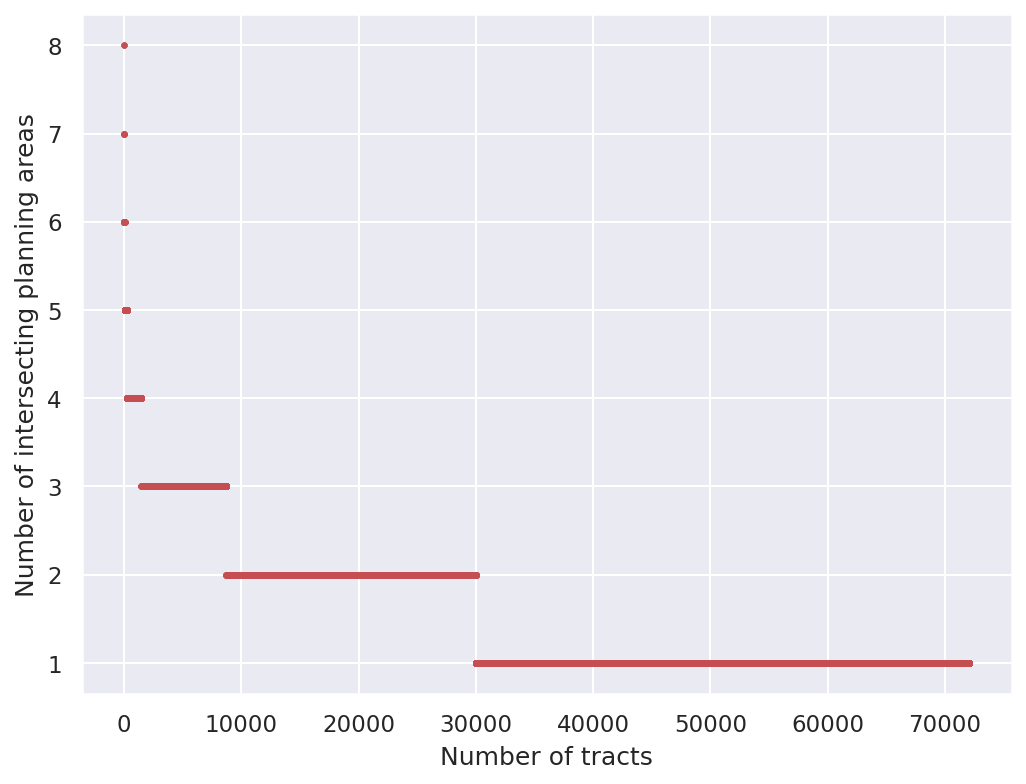

In [18]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot((intersection_matrix != 0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)
plt.xlabel("Number of tracts")
plt.ylabel("Number of intersecting planning areas")
plt.show()

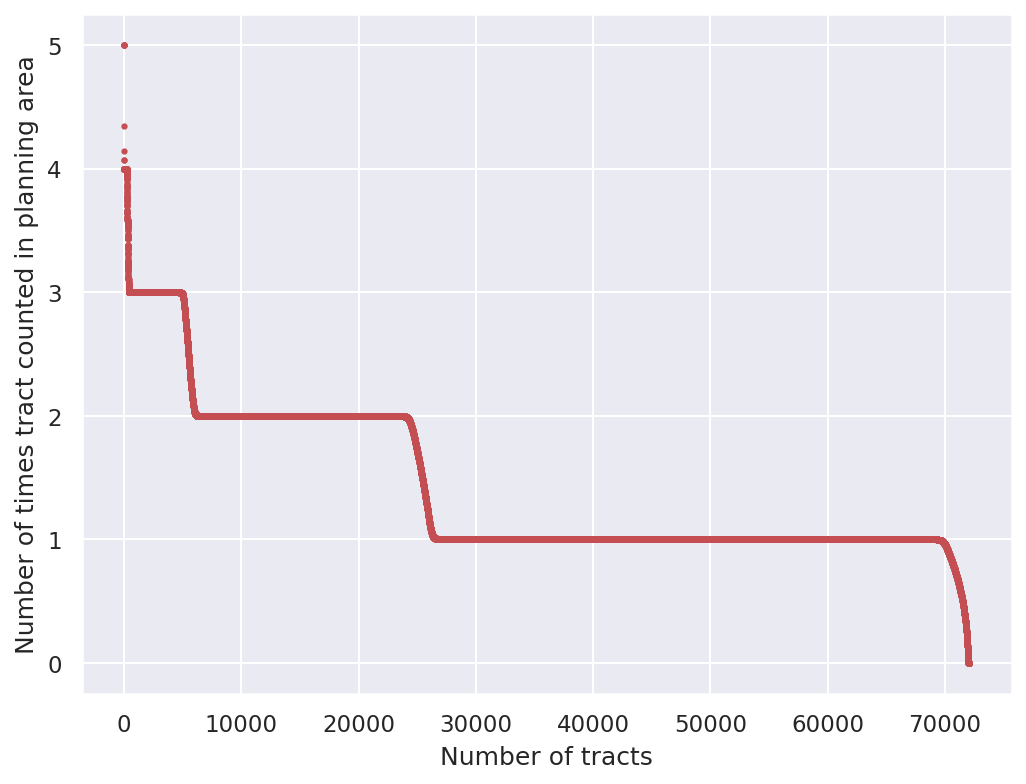

In [19]:
fig, ax = plt.subplots(figsize=(8, 6))
plt.plot(create_intersection_matrix(gdf_intersection, normalization=0)
         .sum(axis=1)
         .sort_values(ascending=False)
         .tolist(), 'ro', ms=2)
plt.xlabel("Number of tracts")
plt.ylabel("Number of times tract counted in planning area")
plt.show()

## Grouping demand data at the county and state level

In [20]:
census_tract_gdf = (
    census_tract_gdf.merge(
        demand_norm_matrix
        .sum(axis=1)
        .reset_index()
        .rename(columns={0: "demand_mwh"})
    )
)

## Created tracts demand aggregated by state
county_gdf = (
    census_tract_gdf[["STCOFIPS", "geometry"]]
    .merge(
        census_tract_gdf
        .groupby("STCOFIPS")[["demand_mwh", "SQMI", "POPULATION"]]
        .sum()
        .reset_index()
    )
)

county_gdf["energy_demand_per_sqmi"] = county_gdf["demand_mwh"] / county_gdf["SQMI"]
county_gdf["demand_per_capita"] = county_gdf["demand_mwh"] / county_gdf["POPULATION"]

## Created tracts demand aggregated by state
state_gdf = (
    census_tract_gdf[["STATE_FIPS", "geometry"]]
    .merge(
        census_tract_gdf
        .groupby("STATE_FIPS")[["demand_mwh", "SQMI", "POPULATION"]]
        .sum()
        .reset_index()
    )
)

state_gdf["energy_demand_per_sqmi"] = state_gdf["demand_mwh"] / state_gdf["SQMI"]

state_gdf["demand_per_capita"] = state_gdf["demand_mwh"] / state_gdf["POPULATION"]

/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/pysal/explore/segregation/network/network.py:15: UserWarning: You need pandana and urbanaccess to work with segregation's network module
You can install them with  `pip install urbanaccess pandana` or `conda install -c udst pandana urbanaccess`
  warn(
/home/zane/miniconda3/envs/pudl-dev/lib/python3.8/site-packages/pysal/model/spvcm/abstracts.py:10: UserWarning: The `dill` module is required to use the sqlite backend fully.
  from .sqlite import head_to_sql, start_sql


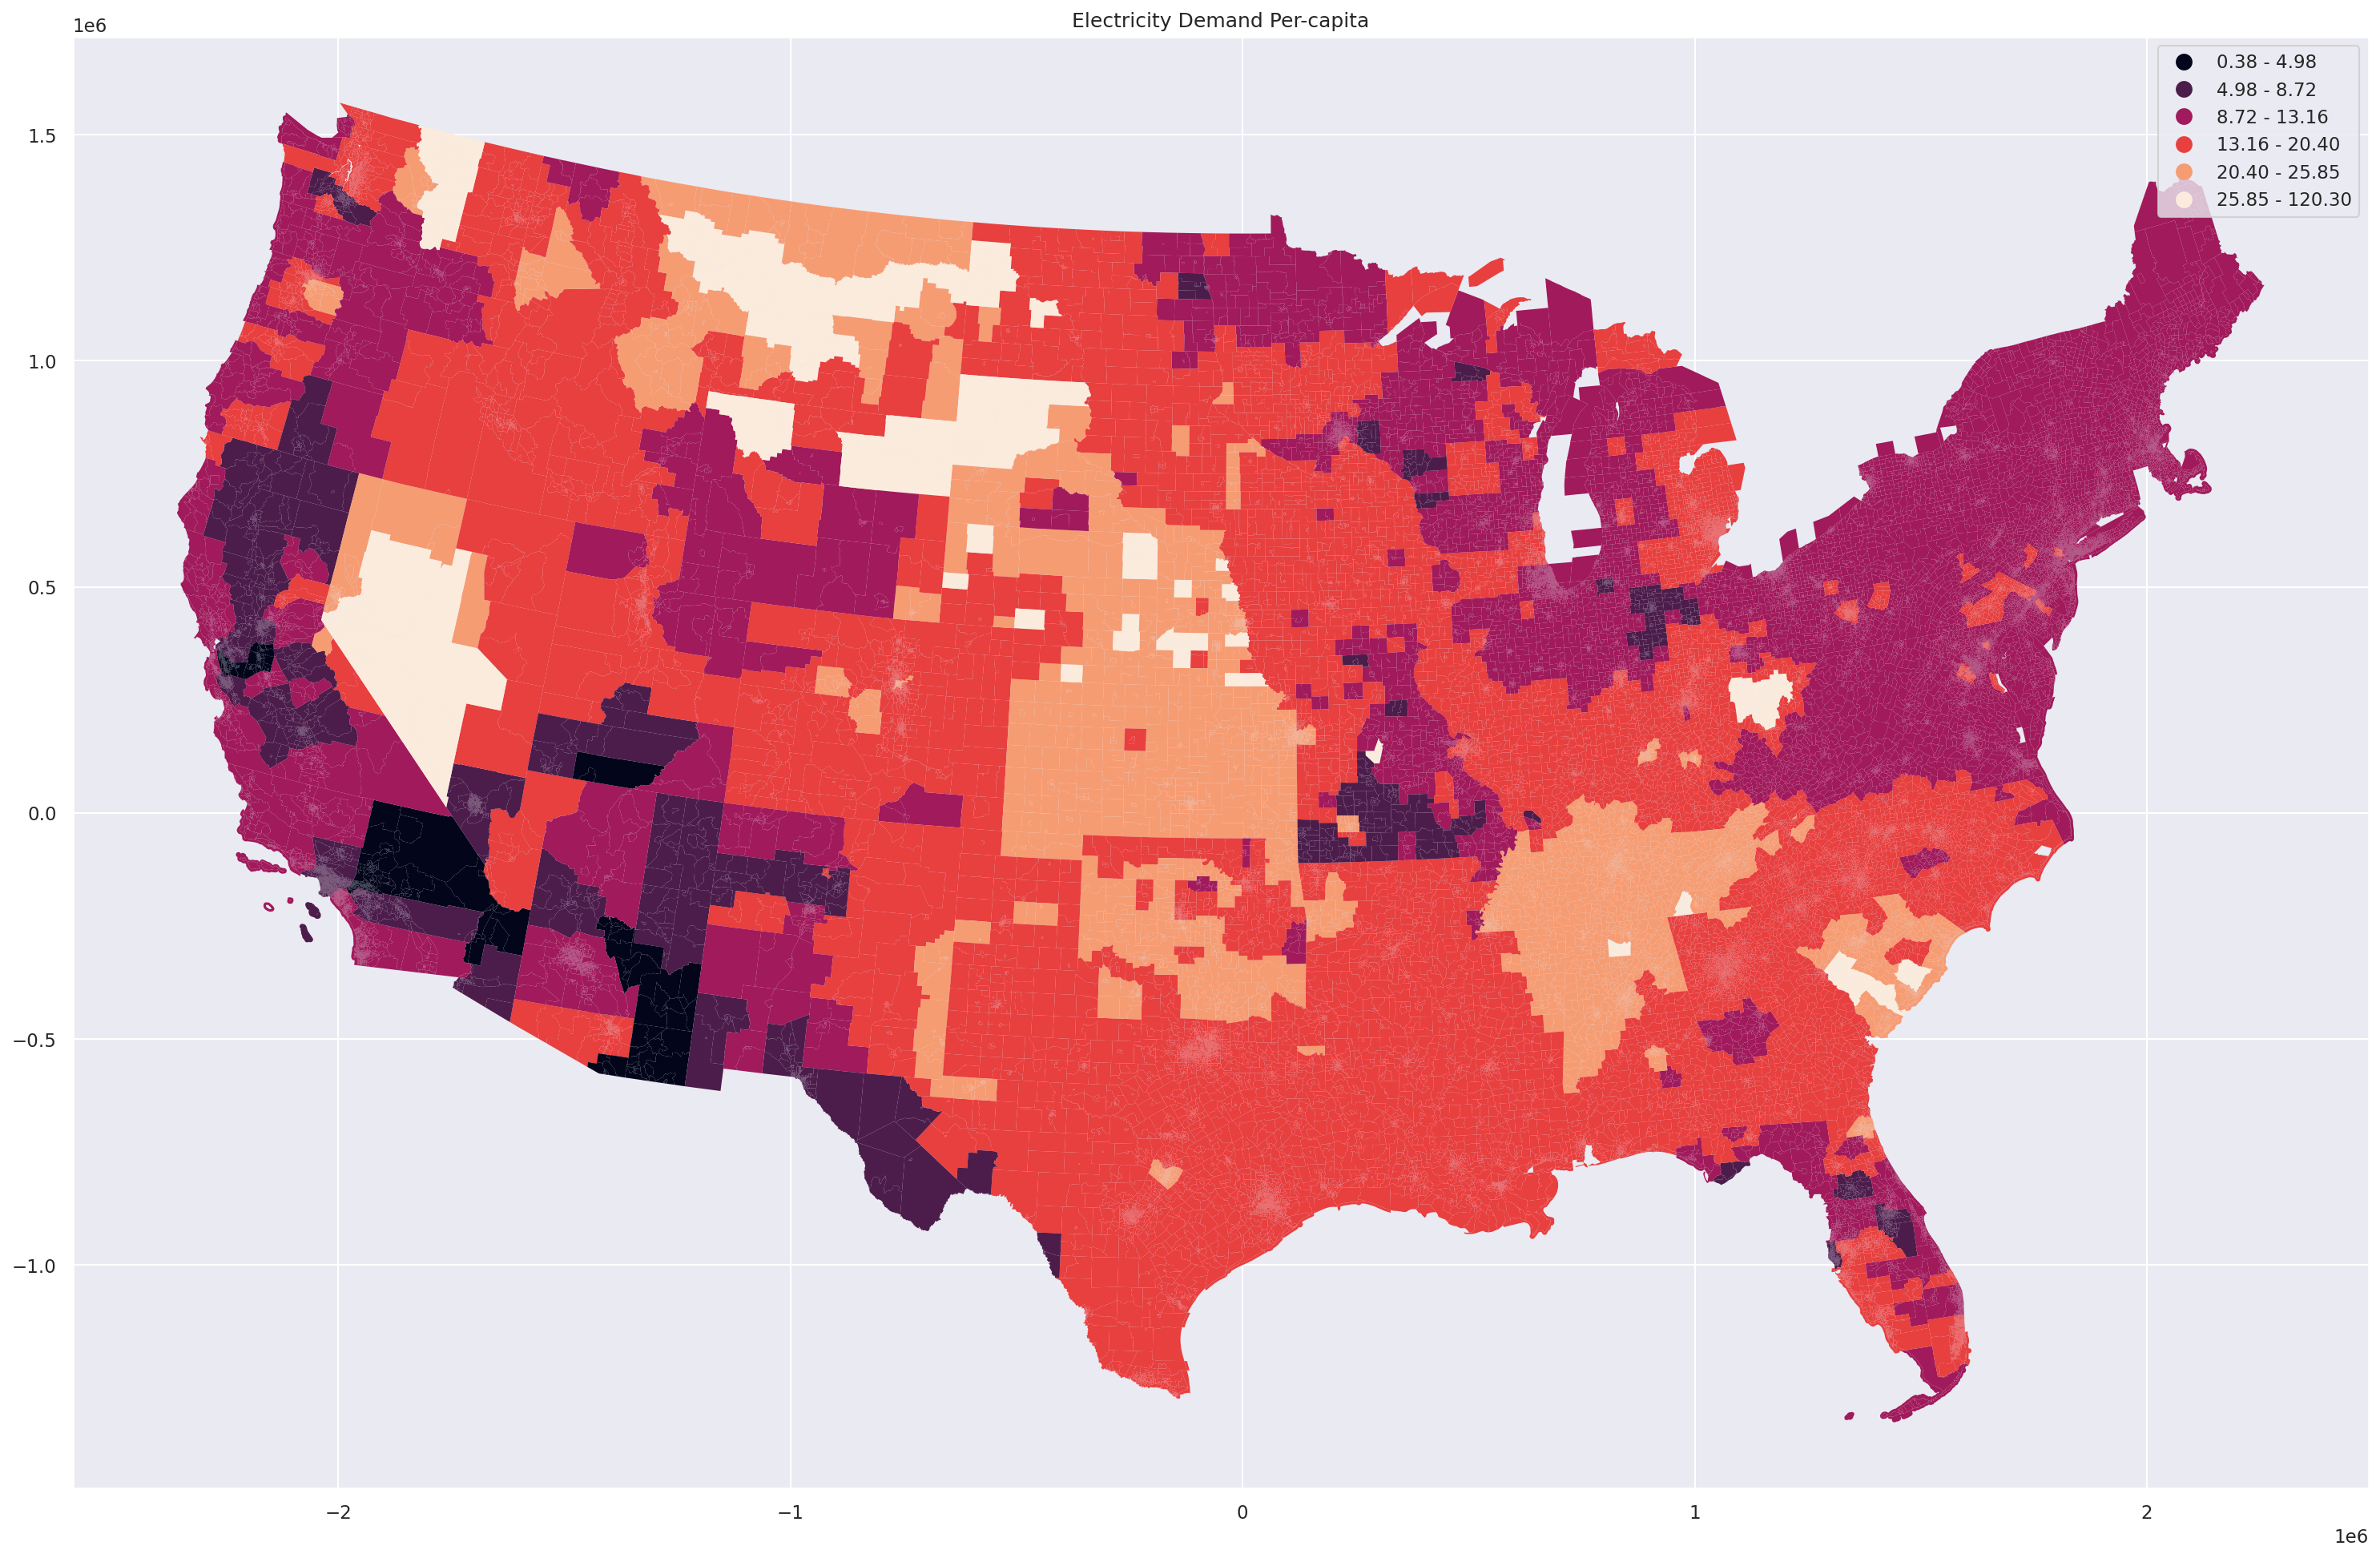

In [21]:
# County level electricity demand per capita
fig, ax = plt.subplots(figsize=(28, 16))
county_gdf.plot(
    column="demand_per_capita",
    ax=ax,
    legend=True,
    scheme="percentiles",
    linewidth=0,
)
plt.title("Electricity Demand Per-capita")
plt.show()

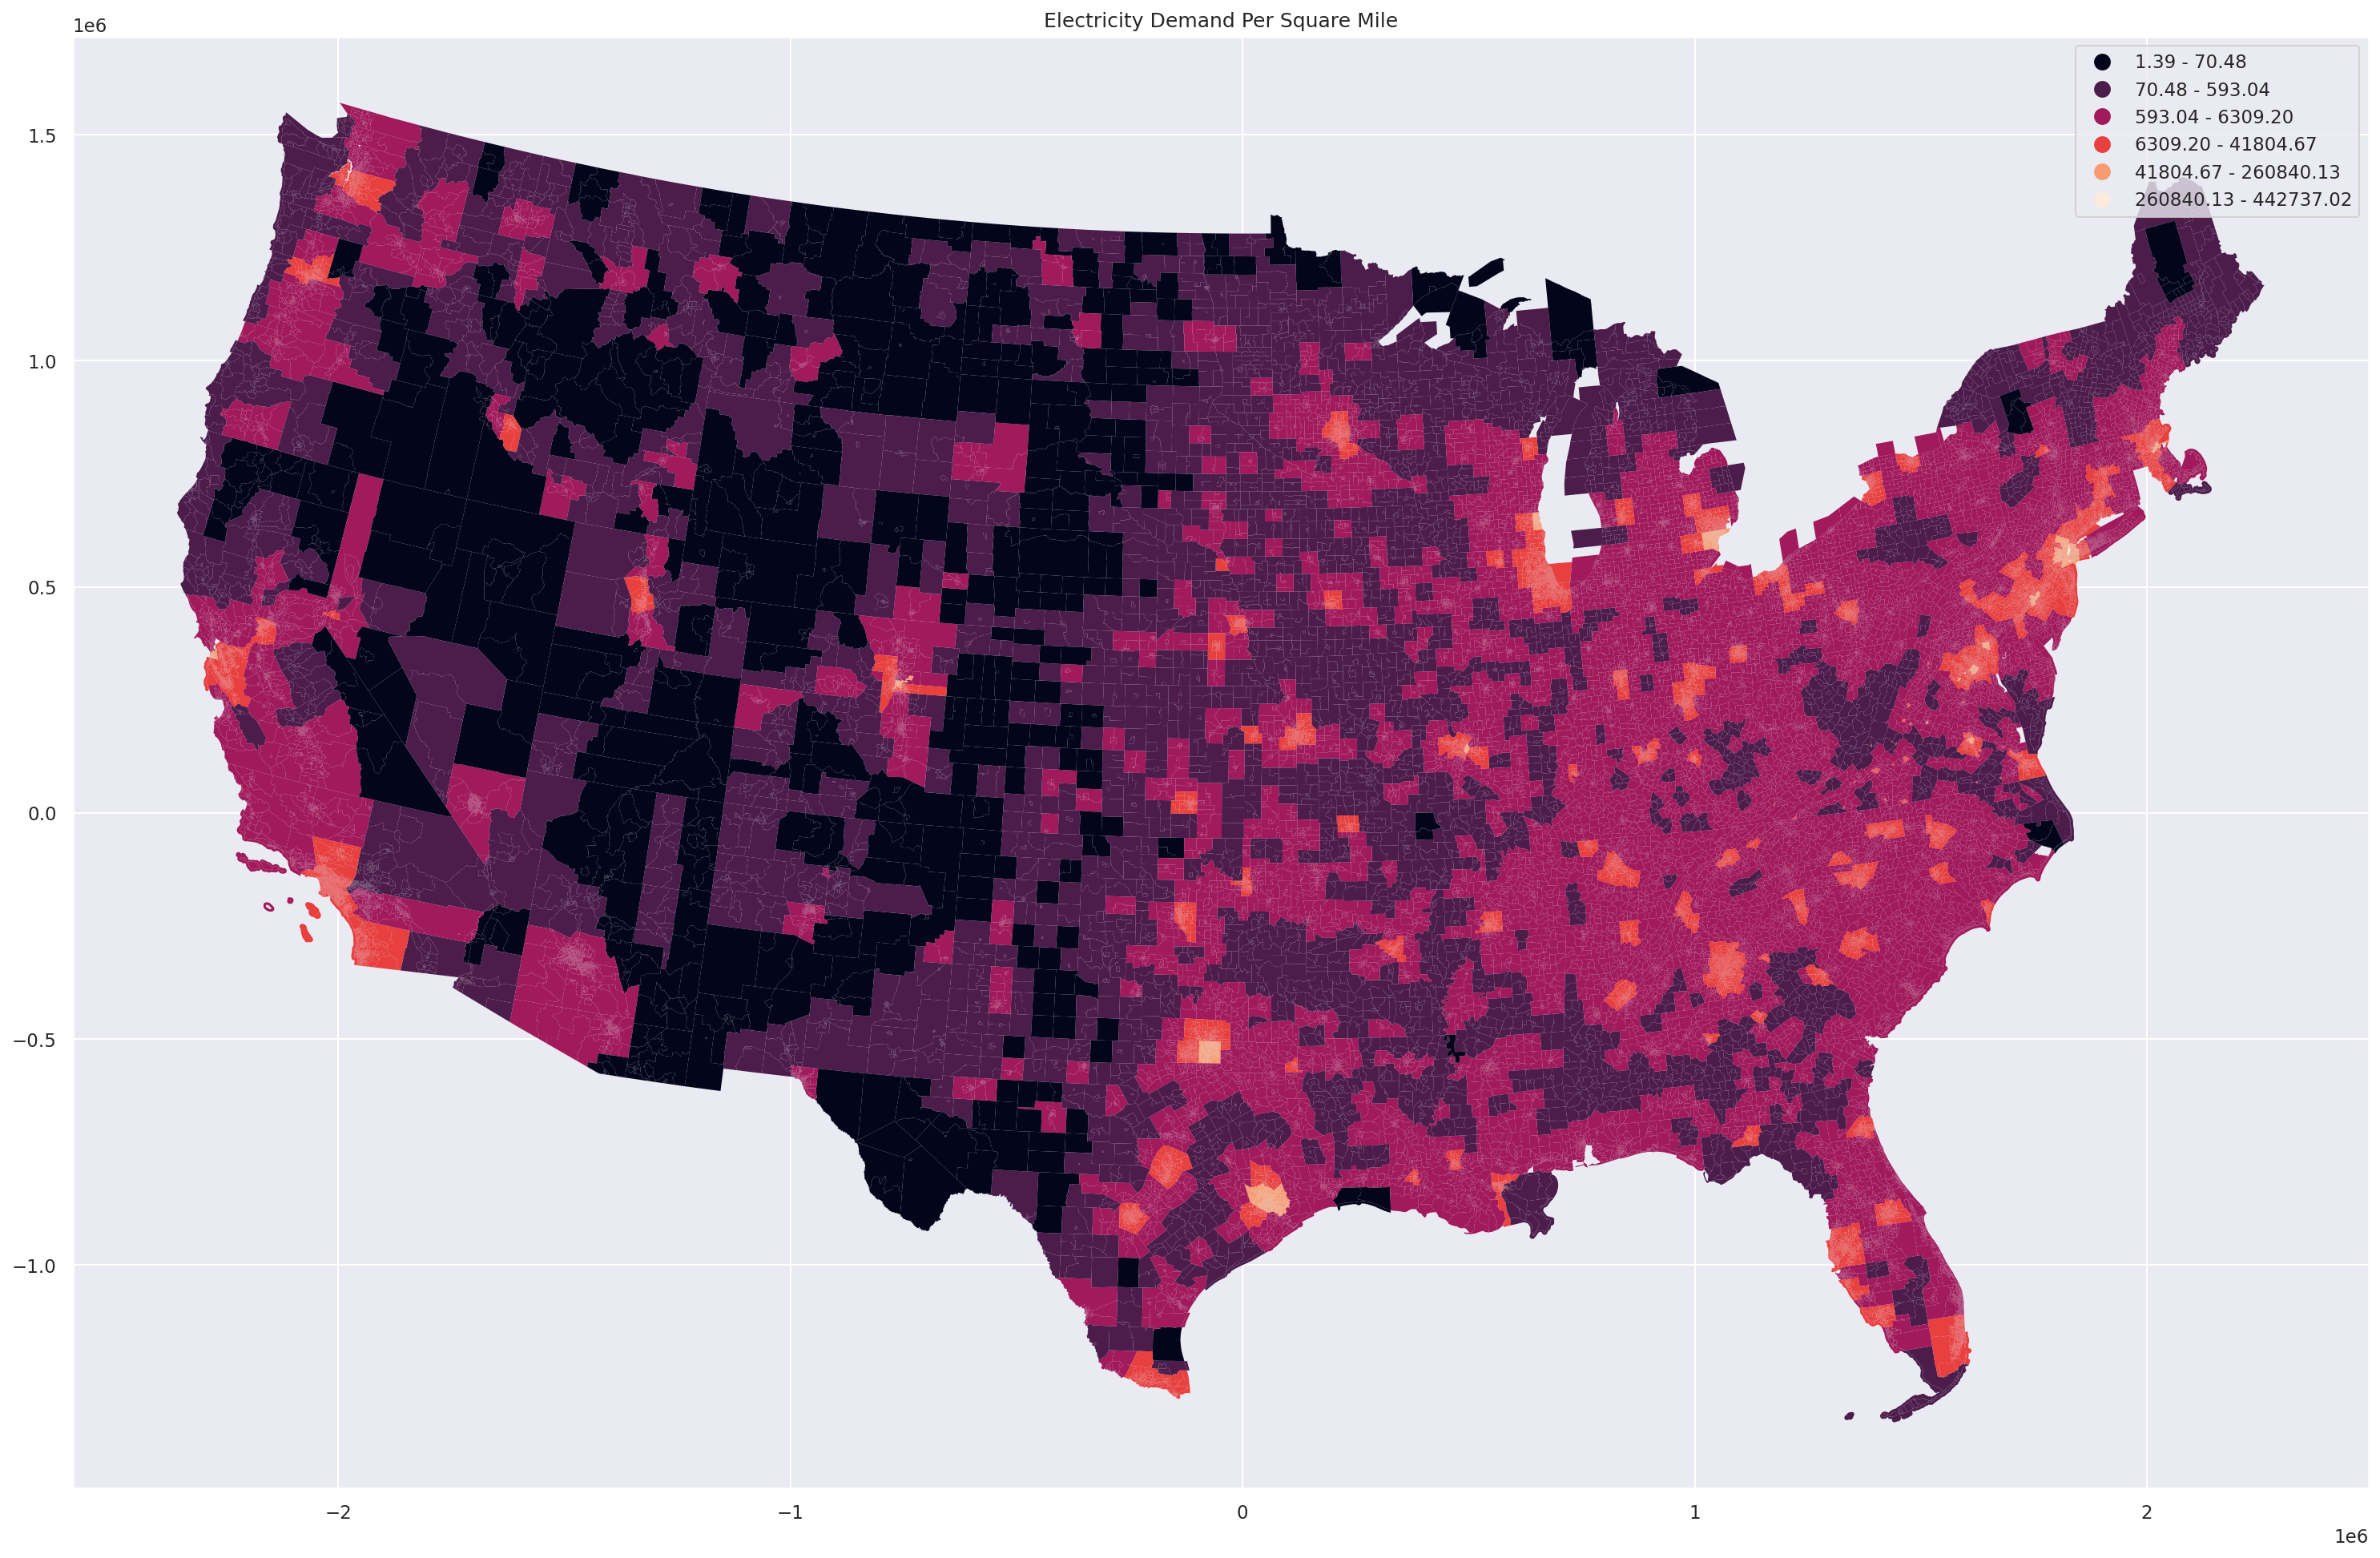

In [22]:
# County demand per unit area
fig, ax = plt.subplots(figsize=(28, 16))
county_gdf.plot(
    column="energy_demand_per_sqmi",
    ax=ax,
    legend=True,
    scheme="percentiles",
    linewidth=0,
)
plt.title("Electricity Demand Per Square Mile")
plt.show()

## Incorporating state annual sales for residential, industrial comparison

In [23]:
sales_df = (state_gdf[["STATE_FIPS", "demand_mwh"]]
            .drop_duplicates()
            .reset_index(drop=True)
            .merge(df_sales_eia_2018, left_on="STATE_FIPS", right_on="FIPS")).drop("FIPS", axis=1)

sales_df = sales_df.sort_values("demand_mwh", ascending=False).reset_index(drop=True)

sales_df["pc_error"] = abs(sales_df["Total"] - sales_df["demand_mwh"]) / sales_df["Total"]


sales_df = sales_df.sort_values("pc_error", ascending=False).reset_index(drop=True)
sales_sum = sales_df["Total"].sum()
allocated_demand_sum = sales_df["demand_mwh"].sum()

sales_df["adjusted_demand"] = sales_df["demand_mwh"] * sales_sum / allocated_demand_sum

sales_df.head()

KeyError: 'FIPS'

In [ ]:
pred = 'adjusted_demand'
actual = "Total"


fig, ax = plt.subplots(figsize=(6, 6))

def r2(x, y):
    
    return scipy.stats.pearsonr(sales_df[actual], sales_df[pred])


slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(sales_df[actual], sales_df[pred])

sns.regplot(x=actual, y=pred, data=sales_df, ax = ax,
            line_kws={'label':"y={0:.2f}x + {1:.1f} (R2 = {2:.2f})".format(slope,intercept,r_value)})


min_lim, max_lim = 0, sales_df[[actual, pred]].max().max()


ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")

plt.xlabel("Total Sales (MWh)")
plt.ylabel("Adjusted Allocated Demand (MWh)")
# ax = sns.jointplot(x="Residential", y="Demand", data=sales_df, stats_func=r2)


ax.legend()
plt.show()

## Allocating demand time series at the state level

In [ ]:
dict_state_tracts = (
    census_tract_gdf
    .groupby("STATE_FIPS")
    .agg({"FIPS": list})
    .to_dict()["FIPS"]
)

dict_statefips_names = (
    states_fips_lookup
    .set_index("FIPS")["Name"]
    .to_dict()
)

dict_statefips_names[11] = "DC"
display(pa_demand_2018.head())
display(pop_norm_matrix.head())

## Disaggregating demand from planning areas and allocating at the state level

In [ ]:
# Utilities that show up in the normalization matrix, but not in the time series:
missing_utils = set(pop_norm_matrix.columns).difference(set(pa_demand_2018.utility_id_eia))

df_state_sales = []
for state_tracts in tqdm(dict_state_tracts.values()):
    df_state_sales.append(
        extract_time_series_demand_multiple_tracts(
            demand_df=pa_demand_2018,
            demand_id_col="utility_id_eia",
            demand_col="demand_mwh",
            time_col="utc_datetime",
            normed_weights=pop_norm_matrix.drop(missing_utils, axis=1),
            target_ids=state_tracts,
        )
    )
    
df_state_sales = pd.concat(
    df_state_sales,
    axis=1,
    keys=[dict_statefips_names[key] + "_Sales" for key in dict_state_tracts.keys()]
)

## Aggregating time series at the monthly level for comparison/visualization along with state sales data

In [ ]:
df_state_sales_monthly = df_state_sales.groupby(pd.Grouper(freq="M")).sum()

df_state_sales_2018 = (df_state_sales_monthly[(df_state_sales_monthly.index >= "2018-01-01") &
                                              (df_state_sales_monthly.index <= "2018-12-31")]
                       .stack()
                       .reset_index()
                       .rename(columns={"level_1": "State", 0: "GWh_allocated"}))

df_state_sales_2018["GWh_allocated"] = df_state_sales_2018["GWh_allocated"] / 1000

df_state_sales_2018["utc_datetime"] = (df_state_sales_2018["utc_datetime"].dt.year * 100 +
                                     df_state_sales_2018["utc_datetime"].dt.month)

df_state_sales_2018["State"] = df_state_sales_2018["State"].str.rstrip('Sales').str.rstrip('_').str.strip()

In [ ]:
## Merging state monthly sales with allocated demand data for comparison
df_check = df_state_sales_2018.merge(df_sales_eia_2018, how="inner")
## Scaling Demand Time Series by a constant factor to make the total sums equal
df_check["GWh_adjusted"] = df_check["GWh_allocated"] * df_check["GWh"].sum() / df_check["GWh_allocated"].sum()
df_check["GWh_allocated"].sum() / df_check["GWh"].sum()

In [ ]:
pred = 'GWh_adjusted'
actual = "GWh"


g = sns.FacetGrid(df_check, col="State", col_wrap=5, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

state_list = df_check["State"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["State"]==state_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

In [ ]:
pred = 'GWh_adjusted'
actual = "GWh"

g = sns.FacetGrid(df_check, col="utc_datetime", col_wrap=4, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

time_list = df_check["utc_datetime"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["utc_datetime"]==time_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
      
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

## Adjusting state bias in the monthly demand allocation

In [ ]:
state_demand_factors = df_check.groupby("State").mean()
state_demand_factors["factor"] = state_demand_factors["GWh"] / state_demand_factors["GWh_adjusted"]
state_demand_factors = state_demand_factors["factor"].to_dict()
state_demand_factors

df_check["state_GWh_adjusted"] = df_check.apply(lambda x: x["GWh_adjusted"] * state_demand_factors[x["State"]],
                                                axis=1)
df_check

In [ ]:
pred = 'state_GWh_adjusted'
actual = "GWh"


g = sns.FacetGrid(df_check, col="State", col_wrap=5, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

state_list = df_check["State"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["State"]==state_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

In [ ]:
pred = 'state_GWh_adjusted'
actual = "GWh"

g = sns.FacetGrid(df_check, col="utc_datetime", col_wrap=4, sharey=False, sharex=False)
g.map(sns.regplot, actual, pred)

time_list = df_check["utc_datetime"].unique().tolist()

counter = 0

for ax in g.axes.flat:
    
    df_temp = df_check[df_check["utc_datetime"]==time_list[counter]]
    min_max = df_temp.describe().loc[["min", "max"], ["GWh", "GWh_adjusted"]]
    
    slope, intercept, r_value, p_value, std_err = scipy.stats.linregress(df_temp[actual], df_temp[pred])
      
    
#     min_lim, max_lim = min_max.min().min(), min_max.max().max()
    min_lim, max_lim = 0, min_max.max().max()
    
    
    ax.plot((min_lim, max_lim), (min_lim, max_lim), ls="--")
    ax.text(max_lim-10, max_lim-10,"y={0:.2f}x + {1:.1f} (R² = {2:.2f})".format(slope,intercept,r_value),
            horizontalalignment='right', verticalalignment="top")
    
    ax.set_ylim(min_lim, max_lim)
    ax.set_xlim(min_lim, max_lim)
    
    
    counter += 1

## Finding intersection area of each census tract with each ReEDS intersection area for demand allocation 

In [ ]:
%%time

# The pickled intersection geometries should be here in this directory:
pickled_reeds_path = pathlib.Path.cwd() / "tracts_reeds_areas_ratios_stacked.pkl"

# If we don't have the saved intersection geometry we need to regenerate it:
if not pickled_reeds_path.is_file():
    logger.info("No precomputed Census tract / ReEDS BA intersections found. Creating them.")
    reeds_intersection_gdf = create_stacked_intersection_df(census_tract_gdf, reeds_gdf, gdf_source_col="OBJECTID")
    pickle.dump(reeds_intersection_gdf, pickled_reeds_path.open(mode="wb"))

# At this point we should definitely have the intersection file available:
with pickled_reeds_path.open(mode="rb") as f:
    logger.info("Reading pre-computed Census tract / ReEDS BA intersections.")
    reeds_intersection_gdf = pickle.load(f)

## Pivoting the mapping to a matrix, and scaling/normalization by individual population, then finding allocated demand accordingly

In [ ]:
reeds_intersection_matrix = create_intersection_matrix(reeds_intersection_gdf,
                                                       gdf_source_col="OBJECTID",
                                                       gdf_intersection_col='gdf_source_intersection_fraction')

pop_norm_reeds = matrix_linear_scaling(reeds_intersection_matrix, census_tract_gdf)

reeds_demand_2018 = matrix_linear_scaling(pop_norm_reeds,
                                          gdf_scale=census_tract_gdf,
                                          gdf_scale_col="demand_mwh",
                                          axis_scale=1)

reeds_gdf = (
    reeds_gdf.set_index("OBJECTID")
    .assign(demand_mwh=reeds_demand_2018.sum(axis=0))
    .reset_index()
)

# Aggregate REEDS data at PCA level
reeds_pca = (
    reeds_gdf
    .drop("demand_mwh", axis=1)
    .merge(
        reeds_gdf
        .groupby("pca_num")["demand_mwh"]
        .sum().reset_index()
    )
)

## Mapping from Census-Planning Areas & Census-REEDS to REEDS-Planning Areas

In [ ]:
drop_fips = (set(pop_norm_reeds[pop_norm_reeds.sum(axis=1) == 0].index)
             .union(set(pop_norm_matrix[pop_norm_matrix.sum(axis=1) == 0].index)))

common_fips = (set(pop_norm_matrix.index)
               .intersection(set(pop_norm_reeds.index))
               .difference(drop_fips))

pop_ferc_reeds= (pop_norm_reeds
                 .loc[common_fips].T
                 .divide(pop_norm_reeds.loc[common_fips]
                         .sum(axis=1))) @ pop_norm_matrix.loc[common_fips]

## Mapping FERC714 demand time series to pca areas

In [ ]:
# Utilities that show up in normalization matrix but not in the time series
missing_utils = set(pop_ferc_reeds.columns).difference(set(pa_demand_2018.utility_id_eia))

dict_reeds_tracts = reeds_gdf.groupby("pca").agg({"OBJECTID": list}).to_dict()["OBJECTID"]

df_reeds_sales = []
for objectids in tqdm(dict_reeds_tracts.values()):
    df_reeds_sales.append(
        extract_time_series_demand_multiple_tracts(
            demand_df=pa_demand_2018,
            demand_id_col="utility_id_eia",
            demand_col="demand_mwh",
            time_col="utc_datetime",
            normed_weights=pop_ferc_reeds.drop(missing_utils, axis=1),
            target_ids=objectids,
        )
    )
    
df_reeds_sales = pd.concat(df_reeds_sales, axis=1, keys=dict_reeds_tracts.keys())
df_reeds_sales_monthly = df_reeds_sales.groupby(pd.Grouper(freq="M")).sum() 

In [ ]:
fig, ax = plt.subplots(figsize=(30, 20))
reeds_pca.plot(
    "demand_mwh",
    ax=ax,
    legend=True,
    scheme="NaturalBreaks"
)
plt.show()

# Analysis of Texas: a tale of two planning areas - SPP and ERCOT)

In [ ]:
ERCOT_SPP_data = pa_demand_2018[
    (pa_demand_2018["utility_id_eia"].isin([17690, 5723])) &
    (pa_demand_2018["utc_datetime"] >= "2018-01-01") &
    (pa_demand_2018["utc_datetime"] < "2019-01-01")]

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))

ax = sns.scatterplot(x="utc_datetime", y="demand_mwh", data=ERCOT_SPP_data, s=1, edgecolor=None,
                     hue="utility_name_ferc714")
plt.title("ERCOT_SPP_Timeseries")


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2019, 1, 1)])

mpl.rcParams.update(mpl.rcParamsDefault)
plt.show()

## Texas Counties: Harris County (ERCOT) vs Potter County (SPP)

Demand was disaggregated into census tracts, allocated on the basis of population and intersecting planning areas. Then, it can be further reaggregated at different levels, like counties, states, ReEDS areas etc.

In [ ]:
# extract_time_series_demand_multiple_tracts(ferc_df, pop_norm_matrix, )
# Utilities that show up in normalization matrix but not in the time series
missing_utils = set(pop_norm_matrix.columns).difference(set(pa_demand_2018.utility_id_eia))

harris_county_fips = census_tract_gdf[census_tract_gdf["FIPS"].str[:5]=="48201"]["FIPS"].tolist()
harris_county_demand = extract_time_series_demand_multiple_tracts(
    demand_df=pa_demand_2018,
    demand_id_col="utility_id_eia",
    demand_col="demand_mwh",
    time_col="utc_datetime",
    normed_weights=pop_norm_matrix.drop(missing_utils, axis="columns"),
    target_ids=harris_county_fips,
)
harris_county_demand = harris_county_demand.reset_index().rename(columns={0:"demand_mwh"})

potter_county_fips = census_tract_gdf[census_tract_gdf["FIPS"].str[:5]=="48375"]["FIPS"].tolist()
potter_county_demand = extract_time_series_demand_multiple_tracts(
    demand_df=pa_demand_2018,
    demand_id_col="utility_id_eia",
    demand_col="demand_mwh",
    time_col="utc_datetime",
    normed_weights=pop_norm_matrix.drop(missing_utils, axis="columns"),
    target_ids=potter_county_fips,
)
potter_county_demand = potter_county_demand.reset_index().rename(columns={0:"demand_mwh"})

sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))

sns.scatterplot(
    x="utc_datetime",
    y="demand_mwh",
    data=potter_county_demand,
    s=1,
    edgecolor=None,
    ax=ax,
    legend=False
)

ax2 = ax.twinx()

sns.scatterplot(
    x="utc_datetime",
    y="demand_mwh",
    data=harris_county_demand,
    s=1,
    edgecolor=None,
    ax=ax2,
    legend=False
)

plt.title("Texas Counties: Harris County (ERCOT) vs Potter County (SPP)")

fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2019, 1, 1)])

ax.set_ylim([0, 1000])

ax.set_ylabel("Potter County Demand (MWh)")
ax.yaxis.set_label_coords(-0.05,0.28)
ax2.set_ylabel('Harris County Demand (MWh)')

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

## Time Series of individual PCAs in Texas

In [ ]:
pca_texas = ["p" + str(num) for num in [48, 57] + list(range(60, 68, 1))]
pca_id_dict = reeds_gdf.groupby("pca").agg({"OBJECTID": list}).to_dict()["OBJECTID"]
pca_id_texas = {k:v for k, v in pca_id_dict.items() if k in pca_texas}
pca_id_texas

df_reeds_tx = df_reeds_sales[pca_id_texas.keys()][(df_reeds_sales.index >= "2018-01-01") &
                                    (df_reeds_sales.index < "2019-01-01")]

df_reeds_tx_unstack = df_reeds_tx.unstack().reset_index().rename(columns={"level_0": "PCA", 0: "demand_mwh"})

In [ ]:
from IPython.display import Image
Image(filename=reeds_path / "reeds_ba_us_11x17.jpg") 

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))


pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[:4]
ax = sns.scatterplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     s=1, edgecolor=None, hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2019, 1, 1)])

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))


pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[-6:]
ax = sns.scatterplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     s=1, edgecolor=None, hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 1, 1), datetime.date(2019, 1, 1)])
ax.set_ylim([0, 3000])

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))


pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[:4]
ax = sns.lineplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 3, 1), datetime.date(2018, 6, 1)])
# ax.set_ylim([0, 3000])

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))

pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[-6:]
ax = sns.lineplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 3, 1), datetime.date(2018, 6, 1)])
ax.set_ylim([0, 3000])
plt.legend(loc="upper left")
plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))


pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[:4]
ax = sns.lineplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 4, 1), datetime.date(2018, 4, 30)])

# Define the date format
date_form = mpl.dates.DateFormatter("%a")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=7))
# ax.set_ylim([0, 3000])

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)

In [ ]:
sns.set(font_scale=1.5)
fig, ax = plt.subplots(figsize=(30, 10))


pcas = df_reeds_tx.sum().sort_values(ascending=False).index.tolist()[-6:]
ax = sns.lineplot(x="utc_datetime", y="demand_mwh",
                     data=df_reeds_tx_unstack[df_reeds_tx_unstack["PCA"].isin(pcas)],
                     hue="PCA", hue_order=pcas)


fig.autofmt_xdate()
ax.set_xlim([datetime.date(2018, 4, 1), datetime.date(2018, 4, 30)])

# Define the date format
date_form = mpl.dates.DateFormatter("%a")
ax.xaxis.set_major_formatter(date_form)

ax.xaxis.set_major_locator(mpl.dates.DayLocator(interval=7))
# ax.set_ylim([0, 3000])

plt.show()
mpl.rcParams.update(mpl.rcParamsDefault)